## TUTORIAL 05 - Discrete Empirical Interpolation Method for non-affine elliptic problems
**_Keywords: discrete empirical interpolation method_**

### 1. Introduction
In this Tutorial, we consider steady heat conduction in a two-dimensional square domain $\Omega = (-1, 1)^2$.
The boundary $\partial\Omega$ is kept at a reference temperature (say, zero). The conductivity coefficient is fixed to 1, while the heat source is characterized by the following expression
$$
g(\boldsymbol{x}; \boldsymbol{\mu}) = \exp\{ -2 (x_0-\mu_0)^2 - 2 (x_1 - \mu_1)^2\} \quad \forall \boldsymbol{x} = (x_0, x_1) \in \Omega.
$$

The parameter vector $\boldsymbol{\mu}$, given by 
$$
\boldsymbol{\mu} = (\mu_0,\mu_1)
$$
affects the center of the Gaussian source $g(\boldsymbol{x}; \boldsymbol{\mu})$, which could be located at any point $\Omega$. Thus, the parameter domain is
$$
\mathbb{P}=[-1,1]^2.
$$

In order to obtain a faster evaluation (yet, provably accurate) of the problem we propose to use a certified reduced basis approximation for the problem. In order to preserve the affinity assumption (for the sake of performance) the discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$.

### 2. Parametrized formulation

Let $u(\boldsymbol{\mu})$ be the temperature in the domain $\Omega$.

We will directly provide a weak formulation for this problem
<center>for a given parameter $\boldsymbol{\mu}\in\mathbb{P}$, find $u(\boldsymbol{\mu})\in\mathbb{V}$ such that</center>

$$a\left(u(\boldsymbol{\mu}),v;\boldsymbol{\mu}\right)=f(v;\boldsymbol{\mu})\quad \forall v\in\mathbb{V}$$

where

* the function space $\mathbb{V}$ is defined as
$$
\mathbb{V} = \left\{ v \in H^1(\Omega(\mu_0)): v|_{\partial\Omega} = 0\right\}
$$
Note that, as in the previous tutorial, the function space is parameter dependent due to the shape variation. 
* the parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu}): \mathbb{V} \times \mathbb{V} \to \mathbb{R}$ is defined by
$$a(u,v;\boldsymbol{\mu}) = \int_{\Omega} \nabla u \cdot \nabla v \ d\boldsymbol{x}$$
* the parametrized linear form $f(\cdot; \boldsymbol{\mu}): \mathbb{V} \to \mathbb{R}$ is defined by
$$f(v;\boldsymbol{\mu}) = \int_\Omega g(\boldsymbol{\mu}) v  \ d\boldsymbol{x}.$$

In [1]:
import sys
sys.path.append("../../MLniCS/")


from mlnics import NN, Losses, Normalization
from dolfin import *
from rbnics import *
import torch
import numpy as np

torch.manual_seed(0)
np.random.seed(0)

## 3. Affine decomposition

The parametrized bilinear form $a(\cdot, \cdot; \boldsymbol{\mu})$ is trivially affine.
The discrete empirical interpolation method will be used on the forcing term $g(\boldsymbol{x}; \boldsymbol{\mu})$ to obtain an efficient (approximately affine) expansion of $f(\cdot; \boldsymbol{\mu})$.

In [2]:
@DEIM()
class Gaussian(EllipticCoerciveProblem):

    # Default initialization of members
    def __init__(self, V, **kwargs):
        # Call the standard initialization
        EllipticCoerciveProblem.__init__(self, V, **kwargs)
        # ... and also store FEniCS data structures for assembly
        assert "subdomains" in kwargs
        assert "boundaries" in kwargs
        self.subdomains, self.boundaries = kwargs["subdomains"], kwargs["boundaries"]
        self.u = TrialFunction(V)
        self.v = TestFunction(V)
        self.dx = Measure("dx")(subdomain_data=subdomains)
        self.f = ParametrizedExpression(
            self, "exp(- 2 * pow(x[0] - mu[0], 2) - 2 * pow(x[1] - mu[1], 2))", mu=(0., 0.),
            element=V.ufl_element())
        # note that we cannot use self.mu in the initialization of self.f, because self.mu has not been initialized yet

    # Return custom problem name
    def name(self):
        return "GaussianDEIM"

    # Return the alpha_lower bound.
    def get_stability_factor_lower_bound(self):
        return 1.

    # Return theta multiplicative terms of the affine expansion of the problem.
    def compute_theta(self, term):
        if term == "a":
            return (1.,)
        elif term == "f":
            return (1.,)
        else:
            raise ValueError("Invalid term for compute_theta().")

    # Return forms resulting from the discretization of the affine expansion of the problem operators.
    def assemble_operator(self, term):
        v = self.v
        dx = self.dx
        if term == "a":
            u = self.u
            a0 = inner(grad(u), grad(v)) * dx
            return (a0,)
        elif term == "f":
            f = self.f
            f0 = f * v * dx
            return (f0,)
        elif term == "dirichlet_bc":
            bc0 = [DirichletBC(self.V, Constant(0.0), self.boundaries, 1),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 2),
                   DirichletBC(self.V, Constant(0.0), self.boundaries, 3)]
            return (bc0,)
        elif term == "inner_product":
            u = self.u
            x0 = inner(grad(u), grad(v)) * dx
            return (x0,)
        else:
            raise ValueError("Invalid term for assemble_operator().")

## 4. Main program
### 4.1. Read the mesh for this problem
The mesh was generated by the [data/generate_mesh.ipynb](data/generate_mesh.ipynb) notebook.

In [3]:
mesh = Mesh("data/gaussian.xml")
subdomains = MeshFunction("size_t", mesh, "data/gaussian_physical_region.xml")
boundaries = MeshFunction("size_t", mesh, "data/gaussian_facet_region.xml")

### 4.2. Create Finite Element space (Lagrange P1)

In [4]:
V = FunctionSpace(mesh, "Lagrange", 1)

### 4.3. Allocate an object of the Gaussian class

In [5]:
problem = Gaussian(V, subdomains=subdomains, boundaries=boundaries)
mu_range = [(-1.0, 1.0), (-1.0, 1.0)]
problem.set_mu_range(mu_range)

### 4.4. Prepare reduction with a reduced basis method

In [6]:
reduction_method = ReducedBasis(problem)
reduction_method.set_Nmax(20, DEIM=21)
reduction_method.set_tolerance(1e-4, DEIM=1e-8)

### 4.5. Perform the offline phase

In [19]:
reduction_method.initialize_training_set(100, DEIM=60)
reduced_problem = reduction_method.offline()

In [20]:
reduction_method.initialize_testing_set(10, DEIM=1)
net = NN.RONN(problem, reduction_method)

In [21]:
input_normalization = Normalization.IdentityNormalization()
output_normalization = Normalization.IdentityNormalization()

In [22]:
pdnn_loss = Losses.PDNN_Loss(net, output_normalization)
pinn_loss = Losses.PINN_Loss(net)
prnn_loss = Losses.PRNN_Loss(net, output_normalization, omega=1.)

In [23]:
NN.train(net, pinn_loss, input_normalization, lr=0.001, epochs=10000)

0 0.527908042767357 	mean error(validation) = 0.8457024762478714
100 0.005640863188225857 	mean error(validation) = 0.16767299733835267
200 0.0022225258973633927 	mean error(validation) = 0.10725075797468989
300 0.0014119944791992274 	mean error(validation) = 0.08271218088516791
400 0.00110075859694726 	mean error(validation) = 0.07358652543714331
500 0.0008921315340744255 	mean error(validation) = 0.0666989880193658
600 0.0007291735588659588 	mean error(validation) = 0.060875780225920176
700 0.0005774469202944174 	mean error(validation) = 0.05489456432420148
800 0.0004181952767350505 	mean error(validation) = 0.047918166151107125
900 0.000285471104404377 	mean error(validation) = 0.041377848319868724
1000 0.00021468313157847066 	mean error(validation) = 0.03830077897234002
1100 0.00018050332498996115 	mean error(validation) = 0.03722643321568975
1200 0.00016014174221004536 	mean error(validation) = 0.036502665674937415
1300 0.00014433726600628002 	mean error(validation) = 0.0357245607

KeyboardInterrupt: 

### 4.6.1. Perform an online solve

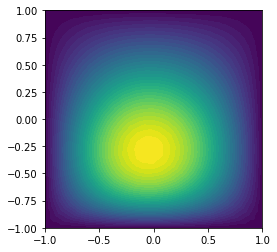

In [28]:
online_mu = (-0.06737845428738742, -0.5111488159967945)#(0.3, -1.0)
reduced_problem.set_mu(online_mu)
reduced_solution = reduced_problem.solve()
plot(reduced_solution, reduced_problem=reduced_problem)

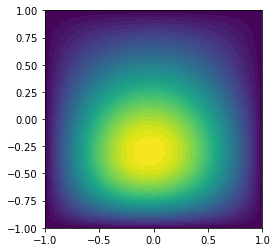

In [29]:
net.eval()
with torch.no_grad():
    online_mu_nn = torch.tensor(online_mu)
    reduced_solution_nn = net.solve(online_mu_nn, input_normalization, output_normalization)
net.train()

plot(reduced_solution_nn, reduced_problem=reduced_problem)

### 4.6.2. Perform an online solve with a lower number of DEIM terms

In [ ]:
reduced_solution_11 = reduced_problem.solve(DEIM=11)
plot(reduced_solution_11, reduced_problem=reduced_problem)

### 4.6.3. Perform an online solve with an even lower number of DEIM terms

In [ ]:
reduced_solution_1 = reduced_problem.solve(DEIM=1)
plot(reduced_solution_1, reduced_problem=reduced_problem)

### 4.7.1. Perform an error analysis

In [ ]:
reduction_method.initialize_testing_set(50, DEIM=60)
reduction_method.error_analysis(filename="error_analysis")

### 4.7.2. Perform an error analysis with respect to the exact problem

In [ ]:
reduction_method.error_analysis(
    with_respect_to=exact_problem, filename="error_analysis__with_respect_to_exact")

### 4.7.3. Perform an error analysis with respect to the exact problem, but employing a smaller number of DEIM terms

In [ ]:
reduction_method.error_analysis(
    with_respect_to=exact_problem, DEIM=11, filename="error_analysis__with_respect_to_exact__DEIM_11")

## 5. Assignments
1. [*] Design now a different problem (e.g. based on the previous tutorials) characterized by several non affine functions. How many times is the discrete empirical interpolation procedure called? Compare the results (errors, speedups) with the original tutorial.